In [1]:
import os, joblib, json, numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score

In [2]:
# load data
project_root = os.path.abspath(os.path.join(os.getcwd()))
processed_path = os.path.join(project_root, "Data", "Processed")

x_train = joblib.load(os.path.join(processed_path, "train_scaled.pkl"))
x_val = joblib.load(os.path.join(processed_path, "val_scaled.pkl"))
x_test = joblib.load(os.path.join(processed_path, "test_scaled.pkl"))
y_test = joblib.load(os.path.join(processed_path, "test_labels.pkl"))

x_train.shape, x_val.shape, x_test.shape

((1638568, 50), (409643, 50), (834347, 50))

## PCA Reconstruction Error ##

In [3]:
# build PCA model
# Keep 95% variance
pca = PCA(n_components=0.98, random_state=42)

pca.fit(x_train)

print("Original features:", x_train.shape[1])
print("Reduced features:", pca.n_components_)

Original features: 50
Reduced features: 15


In [4]:
# Calculate reconstruction error
def reconstruction_error(model, data):
    projected = model.transform(data)
    reconstructed = model.inverse_transform(projected)
    mse = np.mean((data - reconstructed) ** 2, axis=1)
    return mse

train_error = reconstruction_error(pca, x_train)
val_error = reconstruction_error(pca, x_val)
test_error = reconstruction_error(pca, x_test)

In [5]:
# Determine threshold using validation set
threshold = np.percentile(val_error, 91)

print("Threshold:", threshold)

Threshold: 0.04659788489752257


In [6]:
y_pred = (test_error > threshold).astype(int)
# Evaluate metrics
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print(f"\nAccuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred):.4f}")
print("ROC-AUC:", roc_auc_score(y_test, test_error))


Classification Report:

              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87    409643
         1.0       0.90      0.83      0.86    424704

    accuracy                           0.87    834347
   macro avg       0.87      0.87      0.87    834347
weighted avg       0.87      0.87      0.87    834347


Accuracy : 0.8668
Precision: 0.9048
Recall   : 0.8251
F1 Score : 0.8631
ROC-AUC: 0.9456328695883784


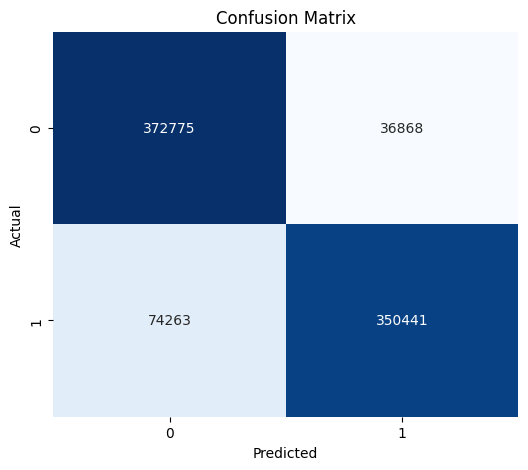

In [7]:
import seaborn as sns
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

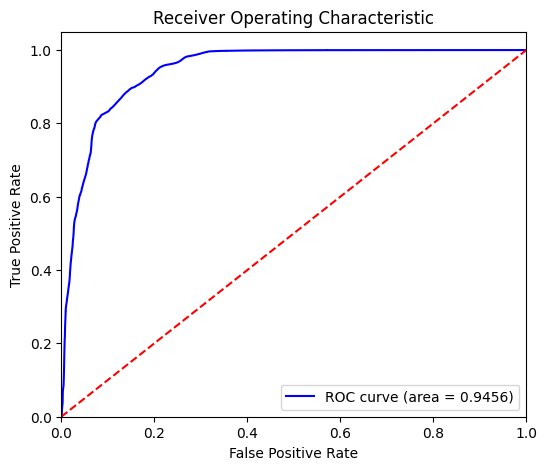

In [8]:
# ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, test_error)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (area = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

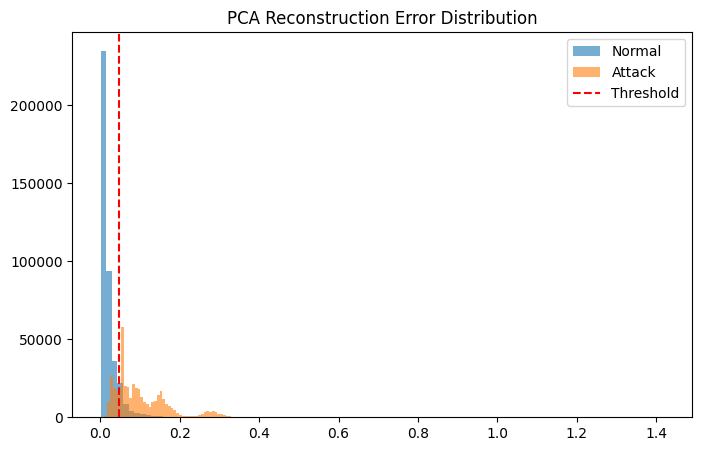

In [9]:
plt.figure(figsize=(8,5))
plt.hist(test_error[y_test==0], bins=100, alpha=0.6, label="Normal")
plt.hist(test_error[y_test==1], bins=100, alpha=0.6, label="Attack")
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.title("PCA Reconstruction Error Distribution")
plt.show()

In [10]:
# save model and threshold
project_root = os.path.abspath(os.path.join(os.getcwd()))
models_path = os.path.join(project_root, "Models")
os.makedirs(models_path, exist_ok=True)

joblib.dump(pca, os.path.join(models_path, "pca_model.pkl"))
joblib.dump(threshold, os.path.join(models_path, "pca_threshold.pkl"))
joblib.dump(train_error, os.path.join(models_path, "pca_train_scores.pkl"))
joblib.dump(val_error, os.path.join(models_path, "pca_val_scores.pkl"))
joblib.dump(test_error, os.path.join(models_path, "pca_test_scores.pkl"))
joblib.dump(y_pred, os.path.join(models_path, "pca_preds.pkl"))

['c:\\Users\\Nourhan\\Documents\\Graduation Project\\AI_Cybersecurity-main\\Models\\pca_preds.pkl']